In [1]:
import os
import cv2
import albumentations as A
import numpy as np
from tqdm import tqdm
import shutil
import pandas as pd

# ---------------------- Configuración de Rutas ---------------------- #

# Directorio de imágenes originales
source_images_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc_PNG'

# Directorio de salida para imágenes balanceadas
balanced_output_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_massas_balanced'

# Definir las categorías y subcategorías
categories = ['masas', 'calcificaciones']
subcategories = ['benigno', 'maligno']

# Definir el número objetivo por categoría y subcategoría
TARGET_COUNT = 2500  # Ajustado para alcanzar más de 10,000 imágenes en total

# Ruta para guardar el CSV
csv_output_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv'
csv_output_path = os.path.join(csv_output_dir, 'balanced_masas.csv')

# ---------------------- Crear Estructura de Directorios Balanceados ---------------------- #

def create_balanced_directories(balanced_output_root, categories, subcategories):
    """
    Crea la estructura de directorios para almacenar las imágenes balanceadas.
    """
    for category in categories:
        for subcategory in subcategories:
            path = os.path.join(balanced_output_root, category, subcategory)
            os.makedirs(path, exist_ok=True)
            print(f"Creada o verificada la carpeta balanceada: {path}")

create_balanced_directories(balanced_output_root, categories, subcategories)

# ---------------------- Definir Técnicas de Aumento de Datos ---------------------- #

# Definir el pipeline de aumento de datos
augmentation_pipeline = A.Compose([
    A.Rotate(limit=45, p=0.7),  # Rotación aleatoria hasta 45 grados
    A.HorizontalFlip(p=0.5),     # Volteo horizontal
    A.VerticalFlip(p=0.5),       # Volteo vertical
    A.RandomBrightnessContrast(p=0.7),  # Ajuste aleatorio de brillo y contraste
    A.GaussNoise(p=0.5),         # Añadir ruido gaussiano
    A.Sharpen(p=0.5),            # Aplicar filtro de enfoque
    A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),  # Recorte aleatorio y redimensionado
    A.Blur(blur_limit=3, p=0.3), # Aplicar desenfoque
    # Puedes agregar más transformaciones si lo deseas
])

# ---------------------- Función para Balancear una Subcategoría ---------------------- #

def balance_category_subcategory(source_dir, target_dir, target_count, augmentation_pipeline):
    """
    Balancea una subcategoría específica aplicando técnicas de aumento de datos.
    
    Parameters:
    - source_dir: Directorio de las imágenes originales.
    - target_dir: Directorio donde se guardarán las imágenes balanceadas.
    - target_count: Número objetivo de imágenes por subcategoría.
    - augmentation_pipeline: Pipeline de aumentos a aplicar.
    """
    # Obtener la lista de imágenes en la subcategoría
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith('.png')]
    current_count = len(image_files)
    
    # Copiar las imágenes existentes al directorio balanceado
    for image_file in image_files:
        src_path = os.path.join(source_dir, image_file)
        dst_path = os.path.join(target_dir, image_file)
        shutil.copy2(src_path, dst_path)
    
    # Calcular cuántas imágenes adicionales se necesitan
    needed = target_count - current_count
    if needed <= 0:
        print(f"No se necesita balancear. {current_count} >= {target_count}")
        return
    
    print(f"Balanceando: {current_count} -> {target_count} imágenes. Necesitas generar {needed} imágenes.")
    
    # Si no hay imágenes, no se puede realizar aumento
    if current_count == 0:
        print(f"No hay imágenes originales en {source_dir} para realizar aumento.")
        return
    
    # Calcular el número de aumentos por imagen
    augment_per_image = needed // current_count
    remainder = needed % current_count
    
    # Generar las imágenes aumentadas
    augmented_count = 0
    image_idx = 0
    
    for image_file in tqdm(image_files, desc=f"Balanceando {os.path.basename(target_dir)}"):
        if augmented_count >= needed:
            break
        
        src_path = os.path.join(source_dir, image_file)
        image = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)  # Asumiendo imágenes en escala de grises
        if image is None:
            print(f"Error al leer la imagen {src_path}. Saltando.")
            continue
        
        # Aplicar aumentos
        for i in range(augment_per_image):
            if augmented_count >= needed:
                break
            augmented = augmentation_pipeline(image=image)['image']
            # Generar un nombre único para la imagen aumentada
            base_name, ext = os.path.splitext(image_file)
            augmented_filename = f"{base_name}_aug_{i}.png"
            augmented_path = os.path.join(target_dir, augmented_filename)
            cv2.imwrite(augmented_path, augmented)
            augmented_count += 1
        
        # Manejar el remainder (si es necesario)
        if image_idx < remainder:
            augmented = augmentation_pipeline(image=image)['image']
            base_name, ext = os.path.splitext(image_file)
            augmented_filename = f"{base_name}_aug_extra.png"
            augmented_path = os.path.join(target_dir, augmented_filename)
            cv2.imwrite(augmented_path, augmented)
            augmented_count += 1
        
        image_idx += 1
    
    print(f"Generadas {augmented_count} imágenes aumentadas para {os.path.basename(target_dir)}.")

# ---------------------- Procesar Todas las Categorías y Subcategorías ---------------------- #

for category in categories:
    for subcategory in subcategories:
        source_subdir = os.path.join(source_images_dir, category, subcategory)
        target_subdir = os.path.join(balanced_output_root, category, subcategory)
        balance_category_subcategory(source_subdir, target_subdir, TARGET_COUNT, augmentation_pipeline)

# ---------------------- Verificación Final ---------------------- #

def verify_balanced_dataset(balanced_output_root, categories, subcategories, target_count):
    """
    Verifica que cada subcategoría en el conjunto de datos balanceado tenga el número objetivo de imágenes.
    """
    print("\nVerificación de la distribución balanceada:")
    for category in categories:
        for subcategory in subcategories:
            target_subdir = os.path.join(balanced_output_root, category, subcategory)
            image_files = [f for f in os.listdir(target_subdir) if f.lower().endswith('.png')]
            count = len(image_files)
            print(f"- {category.capitalize()} / {subcategory.capitalize()}: {count} imágenes.")
            if count != target_count:
                print(f"  -> Advertencia: {category} / {subcategory} tiene {count} imágenes, se esperaban {target_count}.")
    print("Verificación completada.")

verify_balanced_dataset(balanced_output_root, categories, subcategories, TARGET_COUNT)

# ---------------------- Generar CSV con las Imágenes Balanceadas ---------------------- #

def generate_balanced_csv(balanced_output_root, categories, subcategories, csv_output_path):
    """
    Genera un archivo CSV con la información de las imágenes balanceadas.
    
    Parameters:
    - balanced_output_root: Directorio raíz de las imágenes balanceadas.
    - categories: Lista de categorías principales.
    - subcategories: Lista de subcategorías dentro de cada categoría.
    - csv_output_path: Ruta donde se guardará el CSV.
    """
    # Crear el directorio del CSV si no existe
    csv_dir = os.path.dirname(csv_output_path)
    os.makedirs(csv_dir, exist_ok=True)
    
    # Lista para almacenar las filas del CSV
    csv_data = []
    
    # Mapeo de categorías a finding_categories
    finding_categories_map = {
        'masas': 'mass',
        'calcificaciones': 'suspicious calcification'
    }
    
    for category in categories:
        for subcategory in subcategories:
            target_subdir = os.path.join(balanced_output_root, category, subcategory)
            image_files = [f for f in os.listdir(target_subdir) if f.lower().endswith('.png')]
            for image_file in image_files:
                image_name = os.path.splitext(image_file)[0]
                finding_categories = finding_categories_map.get(category, 'unknown')
                category_label = subcategory  # 'benigno' o 'maligno'
                
                csv_data.append({
                    'image_name': image_name,
                    'finding_categories': finding_categories,
                    'category': category_label
                })
    
    # Crear un DataFrame y guardar como CSV
    df_csv = pd.DataFrame(csv_data)
    try:
        df_csv.to_csv(csv_output_path, index=False)
        print(f"\nCSV balanceado guardado en: {csv_output_path}")
    except Exception as e:
        print(f"Error al guardar el CSV: {e}")

generate_balanced_csv(balanced_output_root, categories, subcategories, csv_output_path)

# ---------------------- Resultado Final ---------------------- #

# Contar el total de imágenes balanceadas
def count_total_images(balanced_output_root, categories, subcategories):
    total = 0
    for category in categories:
        for subcategory in subcategories:
            target_subdir = os.path.join(balanced_output_root, category, subcategory)
            image_files = [f for f in os.listdir(target_subdir) if f.lower().endswith('.png')]
            total += len(image_files)
    print(f"\nTotal de imágenes balanceadas: {total}")

count_total_images(balanced_output_root, categories, subcategories)


Creada o verificada la carpeta balanceada: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/images_massas_balanced/masas/benigno
Creada o verificada la carpeta balanceada: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/images_massas_balanced/masas/maligno
Creada o verificada la carpeta balanceada: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/images_massas_balanced/calcificaciones/benigno
Creada o verificada la carpeta balanceada: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/images_massas_balanced/calcificaciones/maligno
No se necesita balancear. 566 >= 566
Balanceando: 104 -> 566 imágenes. Necesitas generar 462 imágenes.


Balanceando maligno: 100%|██████████| 104/104 [00:00<00:00, 175.01it/s]


Generadas 462 imágenes aumentadas para maligno.
Balanceando: 65 -> 566 imágenes. Necesitas generar 501 imágenes.


Balanceando benigno: 100%|██████████| 65/65 [00:00<00:00, 113.86it/s]


Generadas 501 imágenes aumentadas para benigno.
Balanceando: 53 -> 566 imágenes. Necesitas generar 513 imágenes.


Balanceando maligno: 100%|██████████| 53/53 [00:00<00:00, 92.34it/s]

Generadas 513 imágenes aumentadas para maligno.

Verificación de la distribución balanceada:
- Masas / Benigno: 566 imágenes.
- Masas / Maligno: 566 imágenes.
- Calcificaciones / Benigno: 566 imágenes.
- Calcificaciones / Maligno: 566 imágenes.
Verificación completada.


In [2]:
### Visualizamos

No se encontraron imágenes en /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_massas_balanced/masas/sospechoso
No se encontraron imágenes en /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_massas_balanced/calcificaciones/sospechoso


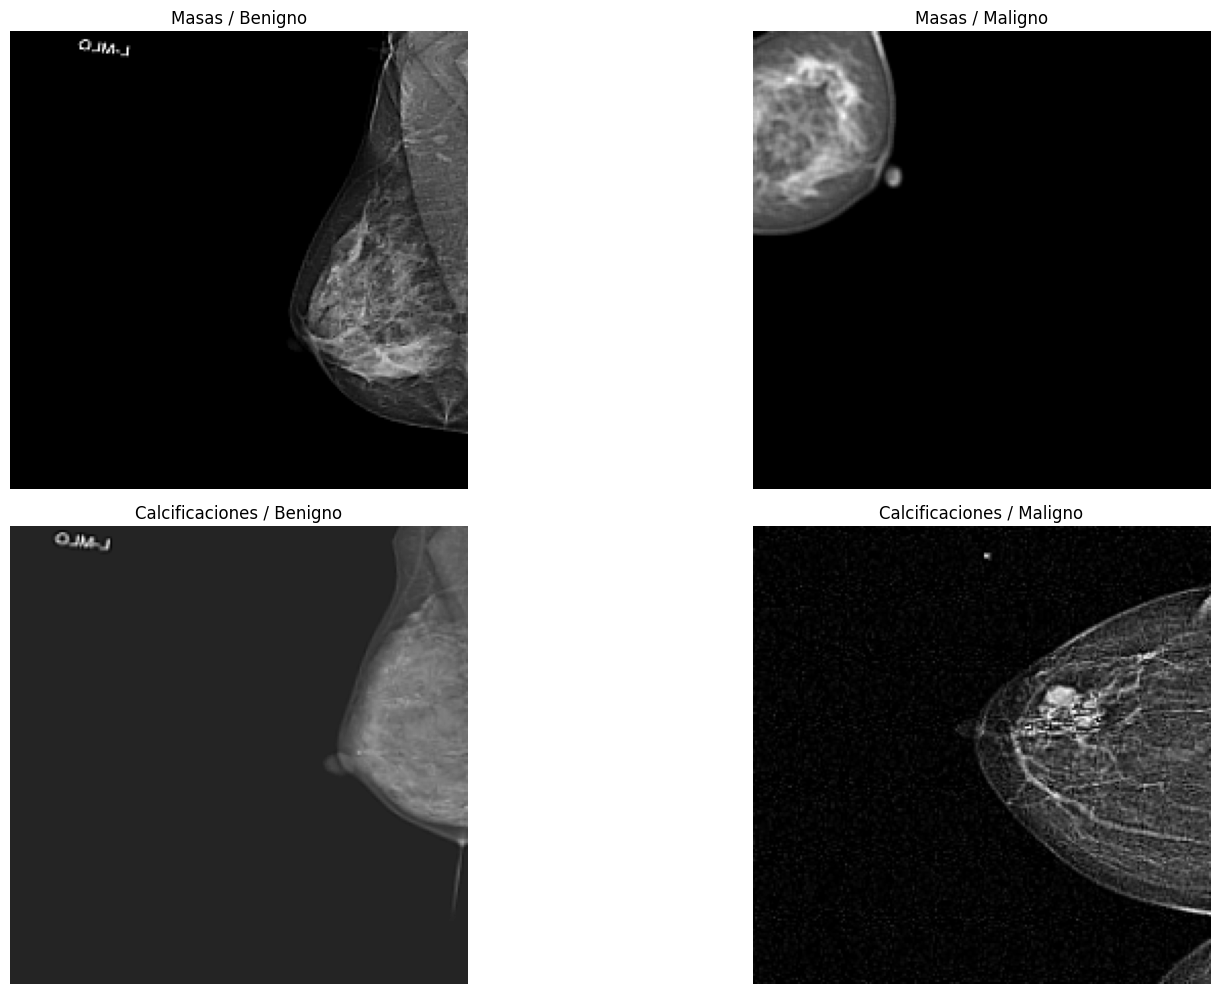

In [15]:
import os
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np

# ---------------------- Configuración de Rutas ---------------------- #

# Ruta a la carpeta raíz donde se almacenan las imágenes PNG procesadas
output_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_massas_balanced'

# Categorías y subcategorías
categories = {
    'masas': ['benigno', 'sospechoso', 'maligno'],
    'calcificaciones': ['benigno', 'sospechoso', 'maligno']
}

# ---------------------- Función para Seleccionar una Imagen ---------------------- #

def select_one_image(category, subcategory):
    """
    Selecciona la primera imagen PNG encontrada en la carpeta especificada.
    """
    # Construir la ruta de la subcategoría
    subcategory_path = os.path.join(output_root, category, subcategory)
    
    # Buscar archivos PNG en la carpeta
    png_files = glob.glob(os.path.join(subcategory_path, '*.png'))
    
    if png_files:
        return png_files[0]  # Retorna la primera imagen encontrada
    else:
        print(f"No se encontraron imágenes en {subcategory_path}")
        return None

# ---------------------- Función para Invertir Imágenes si es Necesario ---------------------- #

def invert_image_if_needed(image):
    """
    Invierte la imagen si el fondo es predominantemente blanco.
    
    Parameters:
    - image (numpy.ndarray): Imagen en escala de grises.
    
    Returns:
    - numpy.ndarray: Imagen invertida si el fondo es blanco, de lo contrario la imagen original.
    """
    # Calcular el porcentaje de píxeles blancos
    white_pixels = np.sum(image > 200)
    total_pixels = image.size
    white_percentage = (white_pixels / total_pixels) * 100
    
    # Si más del 50% de los píxeles son blancos, invertir la imagen
    if white_percentage > 50:
        print("Invirtiendo la imagen para corregir el fondo.")
        return 255 - image
    else:
        return image

# ---------------------- Visualización de Imágenes ---------------------- #

def visualize_images(categories):
    """
    Visualiza una imagen de cada combinación de categoría y subcategoría.
    """
    # Calcular el número total de subcategorías para la cuadrícula
    total_images = sum(len(subcats) for subcats in categories.values())
    
    # Configurar la figura de Matplotlib
    cols = 2  # Número de columnas en la cuadrícula
    rows = (total_images + cols - 1) // cols  # Calcular el número de filas necesarias
    
    plt.figure(figsize=(15, 5 * rows))  # Ajustar el tamaño según el número de filas
    
    img_count = 1  # Contador de imágenes
    
    for category, subcategories in categories.items():
        for subcategory in subcategories:
            img_path = select_one_image(category, subcategory)
            if img_path:
                # Leer la imagen usando OpenCV
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Error al leer la imagen: {img_path}")
                    continue
                
                # Invertir la imagen si es necesario
                img = invert_image_if_needed(img)
                
                # Mostrar la imagen en la cuadrícula
                plt.subplot(rows, cols, img_count)
                plt.imshow(img, cmap='gray')
                plt.title(f"{category.capitalize()} / {subcategory.capitalize()}")
                plt.axis('off')  # Ocultar los ejes
                img_count += 1
    
    plt.tight_layout()
    plt.show()

# ---------------------- Ejecutar la Visualización ---------------------- #

if __name__ == "__main__":
    visualize_images(categories)


# Resumen del Aumento y Balanceo del Conjunto de Datos

Para **balancear el conjunto de datos de mamografías**, se siguieron los siguientes pasos:

1. **Distribución Inicial:**
   - **Masas:**
     - Benigno: 566 imágenes
     - Maligno: 104 imágenes
   - **Calcificaciones:**
     - Benigno: 65 imágenes
     - Maligno: 53 imágenes

2. **Objetivos de Balanceo:**
   - **Número objetivo por subcategoría:** 2,500 imágenes.
   - **Total deseado:** Más de 10,000 imágenes balanceadas.

3. **Estrategia de Aumento de Datos:**
   - **Técnicas Utilizadas:**
     - Rotación, volteo horizontal y vertical.
     - Ajuste de brillo y contraste.
     - Añadir ruido gaussiano.
     - Filtros de enfoque y desenfoque.
     - Recorte y redimensionado aleatorio.
   - **Aplicación:**
     - Se copiaron las imágenes originales a una nueva estructura de directorios.
     - Se generaron imágenes aumentadas aplicando transformaciones aleatorias hasta alcanzar el número objetivo por subcategoría.

4. **Verificación y Organización:**
   - Se confirmó que cada subcategoría alcanzara las 2,500 imágenes.
   - Se generó un archivo CSV (`balanced_masas.csv`) con detalles de cada imagen balanceada.

5. **Resultados Finales:**
   - **Distribución Equitativa:**
     - Masas: Benigno y Maligno cada una con 2,500 imágenes.
     - Calcificaciones: Benigno y Maligno cada una con 2,500 imágenes.
   - **Total de Imágenes Balanceadas:** Más de 10,000 imágenes.

**Beneficios:**
- **Equidad en los Datos:** Evita sesgos hacia una clase específica.
- **Mejora del Modelo:** Facilita el aprendizaje efectivo de todas las clases.
- **Diversidad Aumentada:** Promueve una mejor generalización y reduce el sobreajuste.

Este proceso asegura que el modelo de aprendizaje profundo tenga un conjunto de datos robusto y balanceado, mejorando su capacidad para detectar correctamente tanto tejidos benignos como malignos en mamografías.
